In [1]:
evemb = pd.read_table("embeddings/indication_embedding.csv",index_col=0)
voc = pd.read_table("annotations/indications_vocab.tsv",sep="\t",index_col=0)

In [2]:
## drug to therapeutic groups mapping
(g2thrgrds, thrgrds) = pickle.load(open("annotations/g2thrgrds.pkl",'rb'))
(icd2ccs, ccsdo) =pickle.load(open("annotations/icd2ccs.pkl",'rb'))


In [3]:
icd2phe = pickle.load(open("annotations/icd2phe.03.18.pkl",'rb'))
phe2icd = {p:[i for i,pc in icd2phe.items() if p in pc] for p in set(icd2phe.values())}

In [4]:
cut = 20000
## filter to keep Dx and Rx that are in more than 20000 patients in our data set--we can learn embeddings
dxvoc = voc.loc[(voc['type']=='dx') & (voc['id']>0) & (voc['ct'] > cut),:]
rxvoc = voc.loc[(voc['type']=='rx') & (voc['id']>0) & (voc['ct'] > cut),:]

rxemb = evemb.loc[rxvoc['code'],:]
dxemb = evemb.loc[dxvoc['code'],:]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


In [6]:
len(icd2ccs)

17514

In [7]:
sys.path.append("code/")
import helpers
import plot_helper 
import clustimg

## Overview of indication embeddings

### Figure 2:

Figure 2A

In [195]:
umap.__version__

'0.3.9'

In [8]:
import umap
reducer = umap.UMAP()
#embedding= reducer.fit_transform(X) #np.hstack((np.zeros((X.shape[0],3)),X))[:,3:])
umap_indications = reducer.fit_transform(evemb)
umap_indications = pd.DataFrame(umap_indications, index = evemb.index)


/home/melamed/.local/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/melamed/.local/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../../../../../../home/melamed/.local/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_eucl

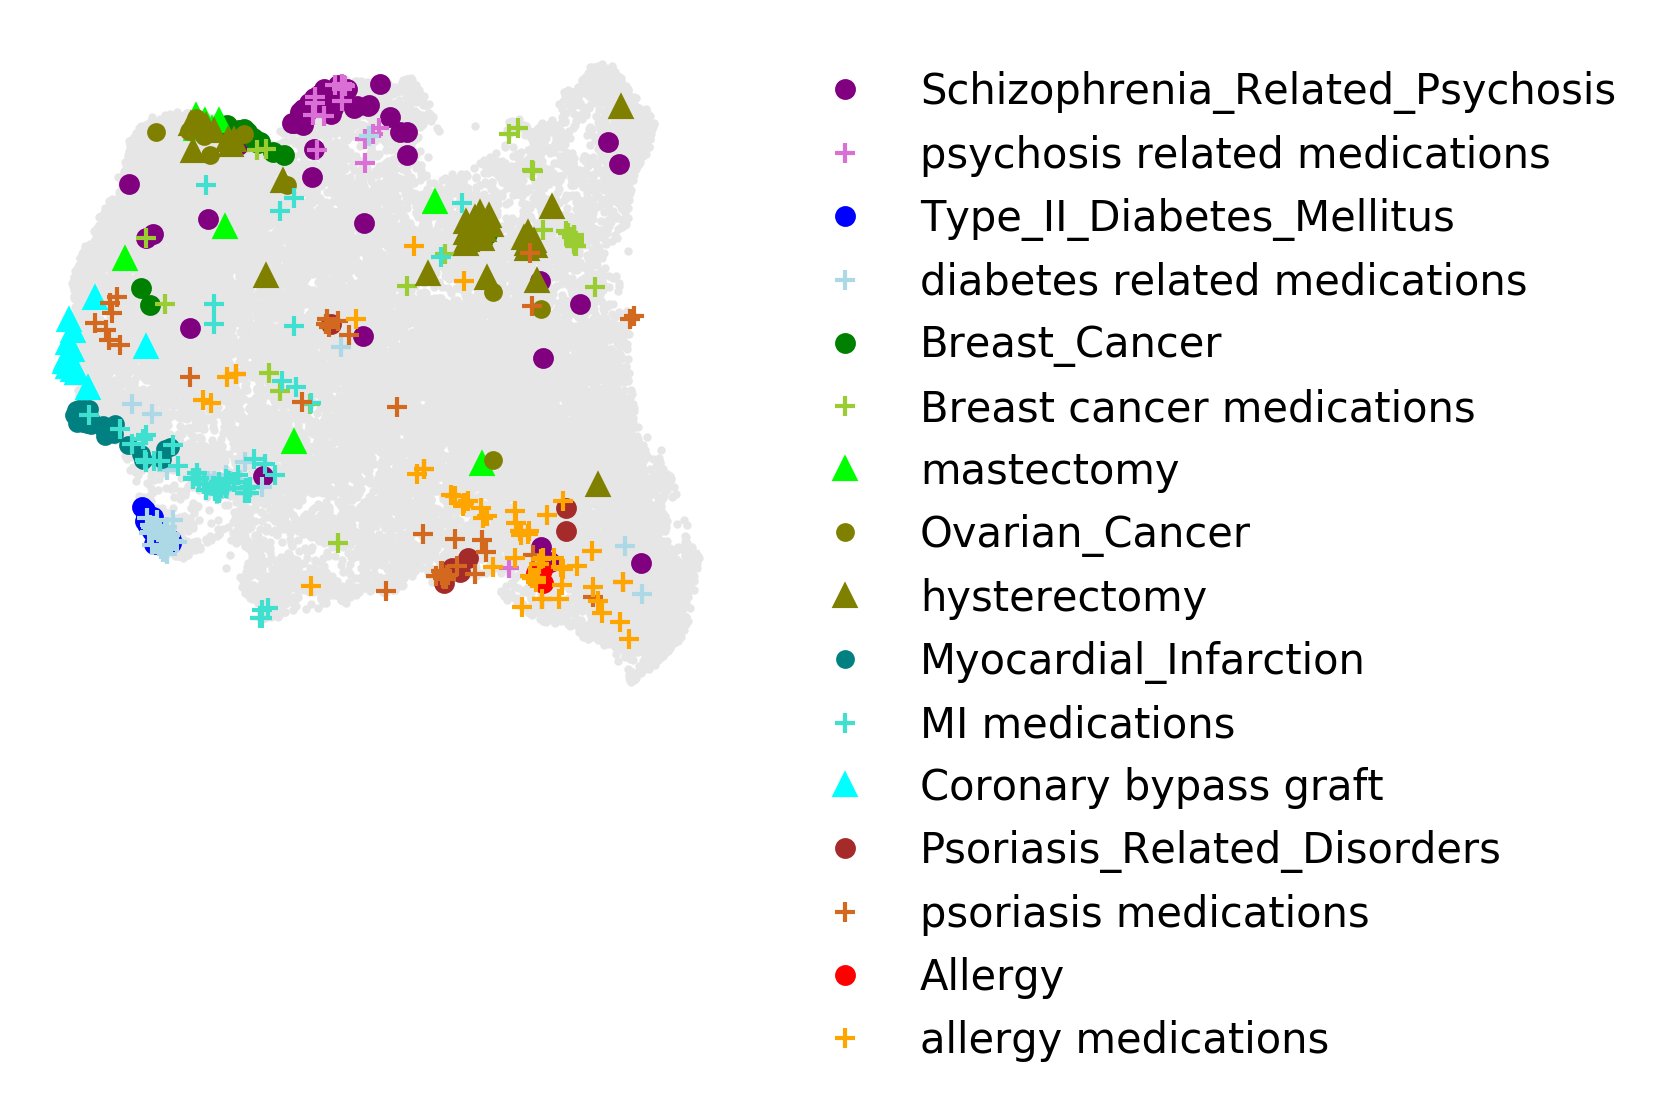

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
for r in ['Residual codes; unclassified; all E codes [259. and 260.]',
          'Symptoms; signs; and ill-defined conditions and factors influencing health status']:
    if r in ccsdo:
        ccsdo.remove(r)


ren = {cc:cc.replace('Diseases of the ','') for cc in ccsdo}

ren['Diseases of the nervous system and sense organs'] = 'Nervous system'
ren['Complications of pregnancy; childbirth; and the puerperium'] = 'Pregnancy/Childbirth'
ren['Diseases of the musculoskeletal system and connective tissue'] = 'Musculoskeletal'
ren['Endocrine; nutritional; and metabolic diseases and immunity disorders'] = 'Endocrine, metabolic, immunity'
ren['Infectious and parasitic diseases'] = 'Infectious disease'
ren['Certain conditions originating in the perinatal period'] = 'perinatal'

jet = plt.get_cmap('tab20')
cNorm = colors.Normalize(vmin=0, vmax=len(ccsdo))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)



dxfemb = umap_indications.loc[voc.loc[(voc['type']=='dx') & (voc['vi']>0) & (voc['ct'] > 100),'code'],:]
rxfemb = umap_indications.loc[voc.loc[(voc['type']=='rx') & (voc['vi']>0) & (voc['ct'] > 100),'code'],:]
pxfemb = umap_indications.loc[voc.loc[(voc['type']=='px') & (voc['vi']>0) & (voc['ct'] > 100),'code'],:]

from collections import defaultdict
hps = pickle.load(open("annotations/MEDI_01212013_HPS.pkl",'rb'))
hps_icd2g = defaultdict(set)
for k,v in hps.items():
    #if len(set([icd2phe[ic] for ic in v])) > 15:
    #    print('skipping', k)
    #    continue
    for dr in v:
        hps_icd2g[k].add(dr)
        
f,ax = plt.subplots(1,figsize=(3,3), dpi=300) #
ax.plot(umap_indications[0], umap_indications[1],".",color=[.9,.9,.9],markersize=2,label='_nolegend_')
topl = dxfemb.loc[set(phe2icd['Schizophrenia_Related_Psychosis']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='purple',markersize=8,label='Schizophrenia_Related_Psychosis')
topl = rxfemb.loc[set(rxfemb.index) & set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Schizophrenia_Related_Psychosis']])),:]
ax.plot(topl[0], topl[1],"+",color='orchid',markersize=5,label='psychosis related medications')

topl = dxfemb.loc[set(phe2icd['Type_II_Diabetes_Mellitus']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='b',markersize=8,label='Type_II_Diabetes_Mellitus')
topl = rxfemb.loc[set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Type_II_Diabetes_Mellitus']])),:]
ax.plot(topl[0], topl[1],"+",color='lightblue',markersize=5,label='diabetes related medications')
#set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Type_II_Diabetes_Mellitus']]))

topl = dxfemb.loc[set(phe2icd['Breast_Cancer']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='g',markersize=8,label='Breast_Cancer')
topl = rxfemb.loc[set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Breast_Cancer']])),:]
ax.plot(topl[0], topl[1],"+",color='yellowgreen',markersize=5,label='Breast cancer medications')
#set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Type_II_Diabetes_Mellitus']]))
pxvoc = pickle.load(open("annotations/px_groups_vocab.pkl",'rb'))
psel  = pxvoc.loc[pxvoc['ccs'].isin(['Mastectomy']),'code']
topl = pxfemb.loc[psel,:]
ax.plot(topl[0], topl[1],"^",color='lime',markersize=5,label='mastectomy')

topl = dxfemb.loc[set(phe2icd['Ovarian_Cancer']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='olive',markersize=7,label='Ovarian_Cancer')

psel  = pxvoc.loc[pxvoc['ccs'].isin(['Hysterectomy, abdominal and vaginal']),'code']
topl = pxfemb.loc[psel,:]
ax.plot(topl[0], topl[1],"^",color='olive',markersize=5,label='hysterectomy')

topl = dxfemb.loc[set(phe2icd['Myocardial_Infarction']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='teal',markersize=7,label='Myocardial_Infarction')
topl = rxfemb.loc[set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Myocardial_Infarction']])),:]
ax.plot(topl[0], topl[1],"+",color='turquoise',markersize=5,label='MI medications')


psel  = pxvoc.loc[pxvoc['ccs'].isin(['Coronary artery bypass graft (CABG)']),'code']
topl = pxfemb.loc[psel,:]
ax.plot(topl[0], topl[1],"^",color='aqua',markersize=5,label='Coronary bypass graft')



topl = dxfemb.loc[set(phe2icd['Psoriasis_Related_Disorders']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='brown',markersize=8,label='Psoriasis_Related_Disorders')
topl = rxfemb.loc[set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Psoriasis_Related_Disorders']])),:]
ax.plot(topl[0], topl[1],"+",color='chocolate',markersize=5,label='psoriasis medications')

topl = dxfemb.loc[set(phe2icd['Allergic_Rhinitis']) & set(dxfemb.index),:]
ax.plot(topl[0], topl[1],".",color='red',markersize=8,label='Allergy')
topl = rxfemb.loc[set(chain.from_iterable([hps_icd2g[d] for d in phe2icd['Allergic_Rhinitis']])),:]
ax.plot(topl[0], topl[1],"+",color='orange',markersize=5,label='allergy medications')


plot_helper.trleg(ax)
plot_helper.hideax(ax)
#plot_helper.saveit(f, "diagnoeses-relateddrugs.pdf")

0


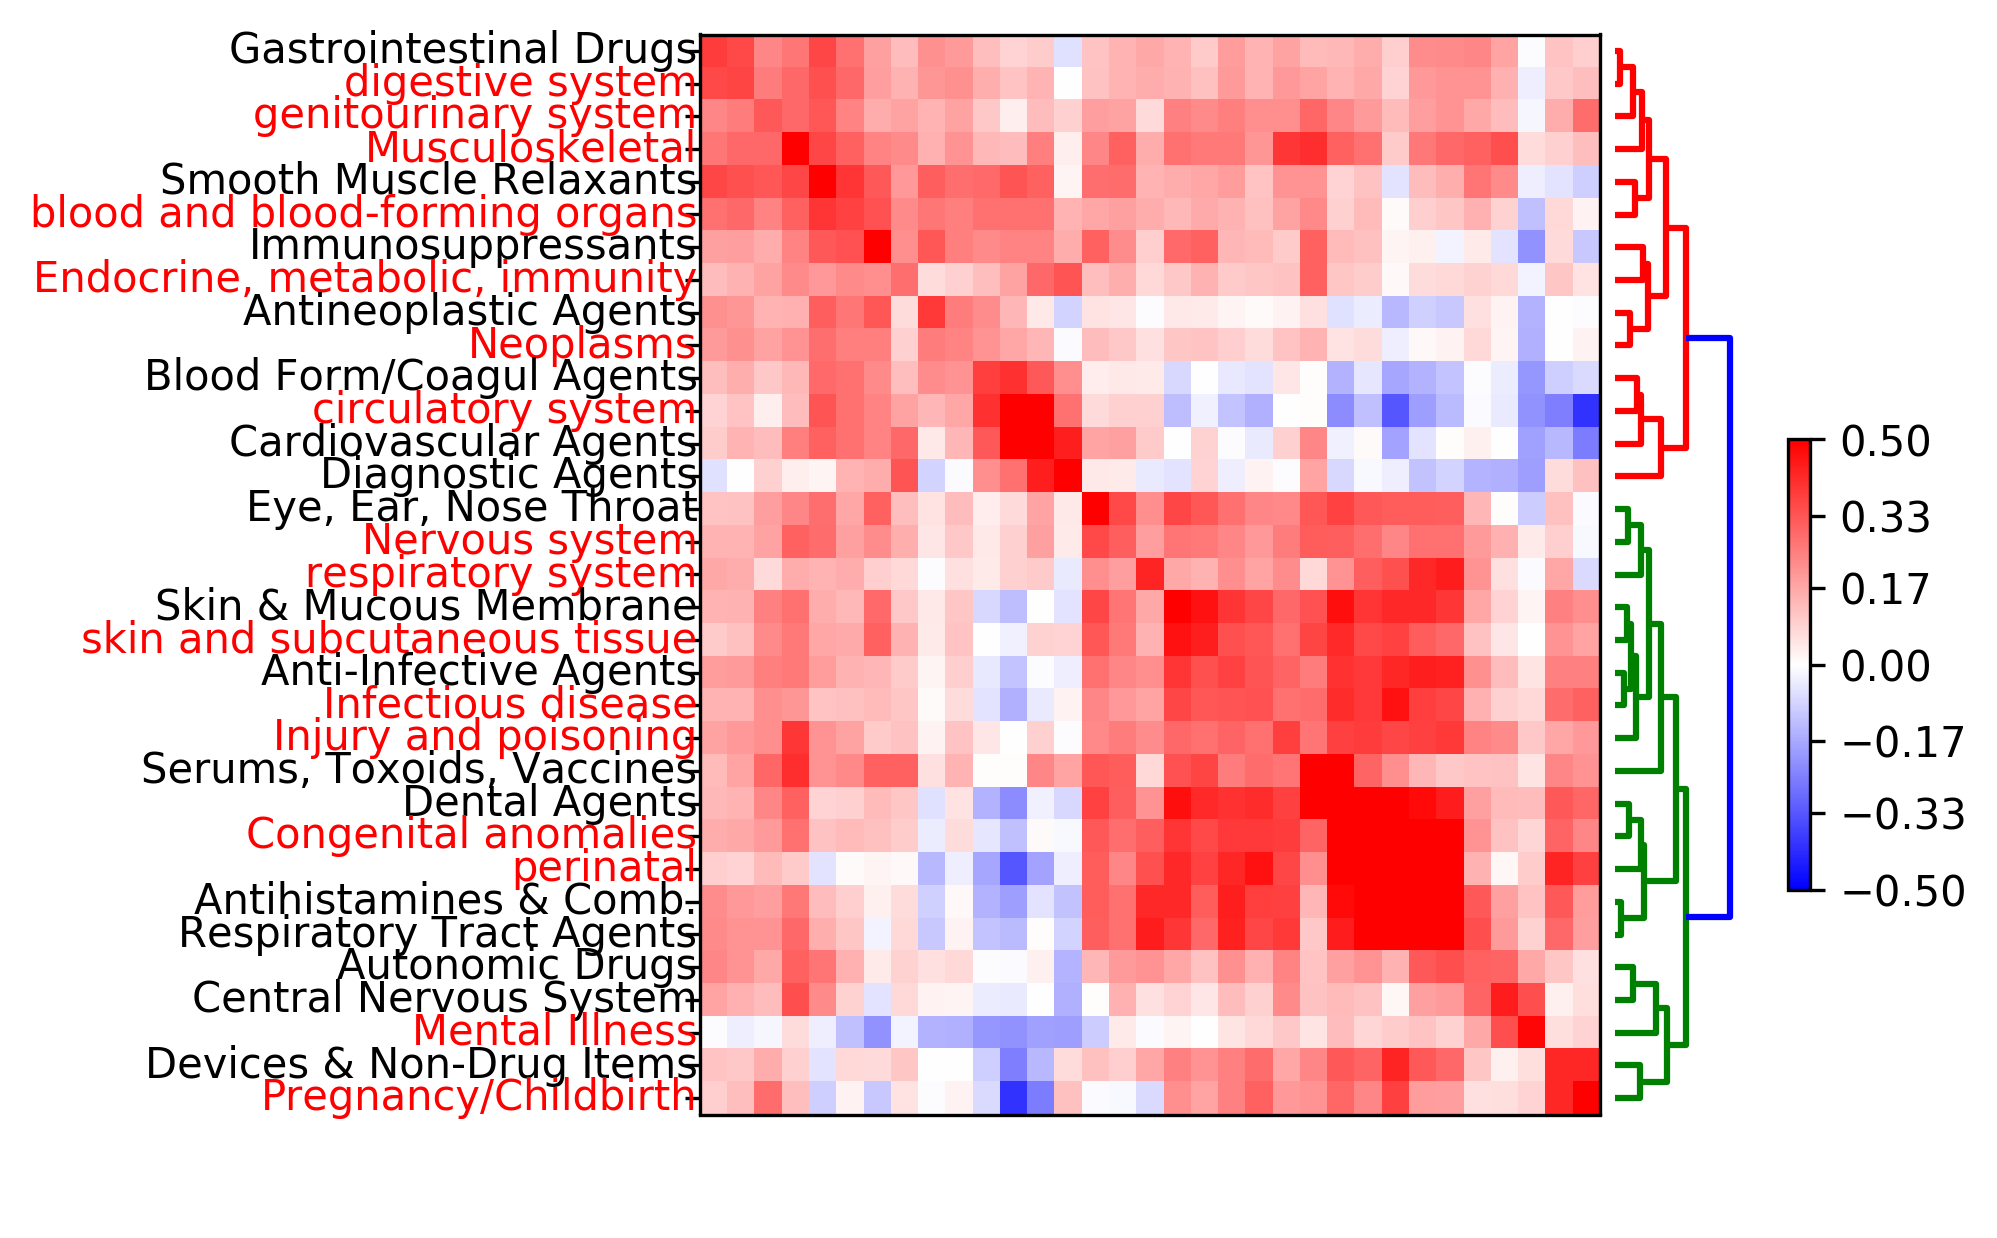

In [11]:
icd2ccs_dict = dict(zip(*tuple((icd2ccs.index, icd2ccs['ccs']))))
ccs2icd = {p:[i for i,pc in icd2ccs_dict.items() if p in pc] for p in set(icd2ccs_dict.values())}
ccsemb = pd.DataFrame(index= ccsdo,columns=np.arange(evemb.shape[1]),dtype=float)
for p in ccsdo:
    ccsemb.loc[p,:] = dxemb.loc[set(ccs2icd[p]) & set(dxemb.index),:].mean(axis=0).values
ccsemb = ccsemb.loc[(pd.isnull(ccsemb).sum(axis=1)==0),:]

grds = pd.DataFrame(index= thrgrds,columns=np.arange(evemb.shape[1]),dtype=float)
for p in thrgrds:
    grds.loc[p,:] = rxemb.loc[set([g for g,k in g2thrgrds.items() if p == k]) & set(rxemb.index),:].mean(axis=0).values
grds = grds.loc[(pd.isnull(grds).sum(axis=1)==0),:]

todot = pd.concat((ccsemb, grds),axis=0)
rddot = todot.dot(todot.transpose())
f = clustimg.clust2way(rddot.astype(float),'bwr',no_row_dendrogram=False ,tickfont=6,cmin=-.5,cmax=.5,no_col_dendrogram=True,sym=True)
f[0].set_size_inches((5,6))
f[1].set_xticklabels([])
f[1].set_xticks([])

f[1].set_yticklabels([])
#dplot.rename(columns={k:k.split("_")[0] for k in dplot.columns})
dpl = rddot.iloc[f[2],:].index
for ix, i in enumerate(dpl):
    color = 'k'
    if i in ccsdo:
        color = 'r'
    f[1].text(-.6,ix,ren[i] if i in ren else i,ha='right',va='center',fontsize=10,color = color)
#f[0].savefig("ccs-grds.tiff", bbox_inches="tight")
    
  

## Using indication embeddings to predict drug therapeutic uses

Using MEDI to evaluate whether the embedding distance is predictive of therapeutic use.

First, parse [MEDI files](https://www.vumc.org/cpm/cpm-blog/medi-ensemble-medication-indication-resource-0), matching them to our ICD-9 codes and to our drug names. I also remove any drugs that are prescribed for more than 15 different diseases (by first mapping ICD-9 code to disease phenotypes):

In [77]:

hps_filt = helpers.parse_medi("annotations/MEDI_01212013_HPS.csv")
medi_all = helpers.parse_medi("annotations/MEDI_01212013.csv") 

Then, using parsed files , get a mapping of drugs to ICD-9 codes to separate indication pairs from non-pairs

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


rxdotdx_sel = rxemb.dot(dxemb.transpose()).transpose()

hps = pickle.load(open("annotations/MEDI_01212013_HPS.pkl",'rb'))
medi = pickle.load(open("annotations/MEDI_01212013.pkl",'rb'))

isind = []
for row in rxdotdx_sel.index:
    isind.append(rxdotdx_sel.columns.isin(hps[row]))
isind = pd.DataFrame(isind,index=rxdotdx_sel.index,columns = rxdotdx_sel.columns)

## filter to ICD and Drug that have at least one indication relationship in the High Precision Set
## after removing those drugs that are nonspecific (prescribed for more than 2% of diseases)
selcol =(isind.sum(axis=0) >= 1)
selrow =(isind.sum(axis=1) >= 1)

isind = isind.loc[selrow,selcol]
rxdotdx_sel = rxdotdx_sel.loc[selrow,selcol]

### full set -- "low precision"
mediisind = []
for row in rxdotdx_sel.index:
    mediisind.append(rxdotdx_sel.columns.isin(medi[row]))
mediisind = pd.DataFrame(mediisind,index=rxdotdx_sel.index,columns = rxdotdx_sel.columns)

### negative = not in High precision set OR in full set of indications
neg = rxdotdx_sel.values.reshape(-1,1)[(~isind & ~mediisind).values.reshape(-1,1)==True]

### positive = high precision set
pos = rxdotdx_sel.values.reshape(-1,1)[isind.values.reshape(-1,1)==True]

print("ROC AUC: {:1.2f}".format(roc_auc_score(np.append(np.ones(pos.shape),np.zeros(neg.shape)), np.append(pos,neg))))

ROC AUC: 0.82


In [11]:
isind.to_csv("annotations/is_indication_hps.txt",sep="\t")
mediisind.to_csv("annotations/is_indication_full.txt",sep="\t")

Comparing to how disproportionately each diagnosis appears before each drug.

In [15]:
dp = pd.read_table("data/pair_stats.txt",sep="\t",index_col=[0,1])
dp['RR']= dp['observed']/dp['expected']

from disproportionality import *
obs2 = np.reshape(dp['observed'],(dp.shape[0],1))
exp2 = np.reshape(dp['expected'],(dp.shape[0],1))
nod = NBin(obs2, exp2)
p = nod.fit(start_params=[6,6])
gammares = do_gps(dp, p)


/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Optimization terminated successfully.
         Current function value: 4.005119
         Iterations: 42
         Function evaluations: 78


In [21]:
gammares.to_csv("result_files/disproportionality_est.csv",sep="\t")
gammares[:5]

observed     expected     N_drug    N_icd        RR  \
            Unnamed: 1                                                        
amoxicillin 153.9         1077.0  1734.328713  9592745.0  81978.0  0.620990   
            429.9          892.0  1309.811892  9592745.0  61912.0  0.681014   
            366.00         210.0   231.616174  9592745.0  10948.0  0.906672   
            366.03         195.0   241.876847  9592745.0  11433.0  0.806195   
            366.02         147.0   218.964871  9592745.0  10350.0  0.671341   

                           scale        shape    ebg.05    ebg.95  
            Unnamed: 1                                             
amoxicillin 153.9       0.000576  1078.727782  0.590690  0.652932  
            429.9       0.000763   893.727782  0.644540  0.719534  
            366.00      0.004292   211.727782  0.808416  1.013727  
            366.03      0.004111   196.727782  0.716213  0.905763  
            366.02      0.004538   148.727782  0.586534  0.768445

In [20]:
dpm = pd.DataFrame(gammares['RR']).transpose().stack()
dpm.index = dpm.index.droplevel(0)
dpm = dpm.mask(pd.isnull(dpm),other=.6) ## mask out not obs
dpm = dpm.mask(dpm < .6,other=.6) ## mask out low DP, no meaning for this purpose
dpm = dpm.loc[rxdotdx_sel.index, rxdotdx_sel.columns]
neg = dpm.values.reshape(-1,1)[(~isind & ~mediisind).values.reshape(-1,1)==True]
pos = dpm.values.reshape(-1,1)[isind.values.reshape(-1,1)==True]
print("ROC AUC: {:1.2f}".format(roc_auc_score(np.append(np.ones(pos.shape),np.zeros(neg.shape)), np.append(pos,neg))))

ROC AUC: 0.80


### Figure 3

In [99]:
rxvoc.sort_values('ct',ascending=False)[:15]

,code,id,name,type,ct,clid,superid,vi
497,azithromycin,2925,azithromycin,rx,24647838,498.0,186,1190
227,acetaminophen_hydrocodone_bitartrate,1401,acetaminophen_hydrocodone_bitartrate,rx,22664582,228.0,38,564
1001,amoxicillin,5790,amoxicillin,rx,22494575,1002.0,183,2379
6,amoxicillin_clavulanate_potassium,47,amoxicillin_clavulanate_potassium,rx,13461086,7.0,183,20
109,cephalexin,717,cephalexin,rx,11658480,110.0,159,288
523,ciprofloxacin_hydrochloride,3129,ciprofloxacin_hydrochloride,rx,10381503,524.0,"176,171",1277
908,prednisone,5305,prednisone,rx,10355459,909.0,27,2167
485,fluticasone_propionate,2829,fluticasone_propionate,rx,9596629,486.0,"166,27,125",1147
787,albuterol_sulfate,4830,albuterol_sulfate,rx,9506945,788.0,218,1870
1093,ibuprofen,6352,ibuprofen,rx,9496986,1094.0,210,2602


We can also make an AUC value for each drug, how good are we at predicting indications for that drug. And conversely for each ICD-9., how good at predicting indicated drugs.

skip Residual codes; unclassified; all E codes [259. and 260.]
skip Certain conditions originating in the perinatal period


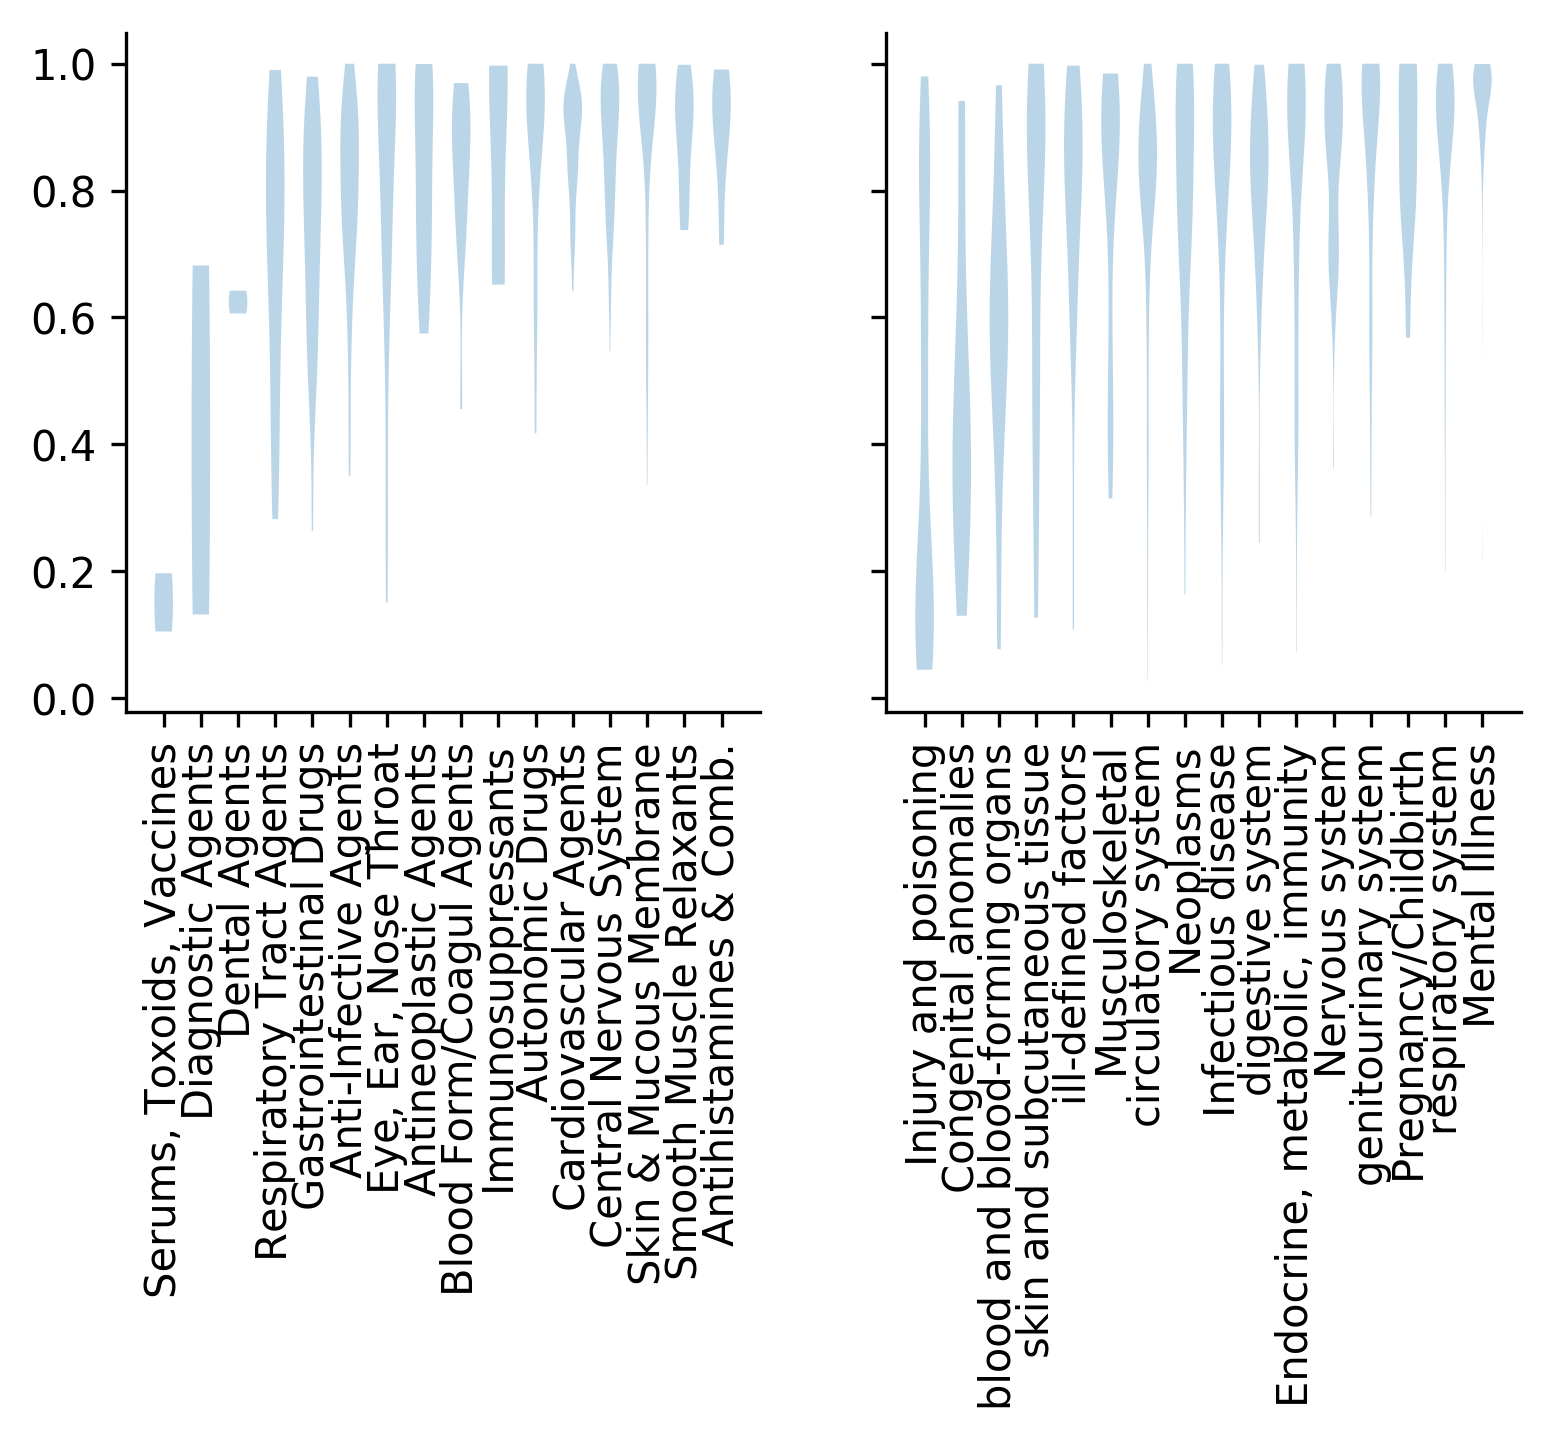

In [22]:
toremove = ~isind & mediisind

dotroc = {}
for drug in rxdotdx_sel.columns:
    r = ~toremove[drug]
    if isind.loc[r,drug].mean()==0:
        continue
    dotroc[drug] = roc_auc_score(isind.loc[r,drug], rxdotdx_sel.loc[r,drug])
    
auc = pd.DataFrame(dotroc,index=['auc']).transpose().sort_values('auc')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = plt.get_cmap('tab20')
auc['xval']= np.arange(auc.shape[0])
cNorm = colors.Normalize(vmin=0, vmax=len(thrgrds))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#f,ax = plt.subplots(1,figsize=(5,5)) #[.8,.8,.8]

#ax.plot(auc['xval'], auc['auc'],'.',color=[.6,.6,.6])
viol = {}
for i,cc in enumerate(thrgrds):
    colorVal = scalarMap.to_rgba(i)
    gdo = set([g for g,v in g2thrgrds.items() if not pd.isnull(g2thrgrds[g]) and cc in v]) & set(auc.index)
    subset = auc.loc[gdo,:]
    #ax.plot(subset['xval'], subset['auc'],".",color=colorVal,markersize=4,label=cc)
    viol[cc] = subset['auc'].values
    
order = [(k,v.mean(),len(v)) for k,v in viol.items() if len(v) > 0 ]
order = pd.DataFrame(order).sort_values(1)
f, ax = plt.subplots(1,2, figsize = (6,3),dpi = 300,sharey=True)
ax[0].violinplot([viol[i] for i in order[0]], showextrema=False)
ax[0].set_xticks(np.arange(1,order.shape[0]+1))
ax[0].set_xticklabels(order[0],rotation=90)
plot_helper.hidespine(ax[0])


dotroc = {}
for drug in rxdotdx_sel.index: # dxdot.index:
    r = ~toremove.loc[drug]
    if isind.loc[drug,r].mean()==0:
        continue
    #dotroc[drug] = roc_auc_score(isind.loc[drug,r], dxdot.loc[drug,r])
    dotroc[drug] = roc_auc_score(isind.loc[drug,r], rxdotdx_sel.loc[drug,r])
    
aucdx = pd.DataFrame(dotroc,index=['auc']).transpose().sort_values('auc')
aucdx = aucdx.sort_values('auc')
aucdx['xval'] = np.arange(aucdx.shape[0])
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = plt.get_cmap('tab20')
cNorm = colors.Normalize(vmin=0, vmax=len(ccsdo))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#f,ax = plt.subplots(1,figsize=(5,5)) #[.8,.8,.8]
todo = list(icd2ccs.loc[icd2ccs['ccs'].str.contains(cc),:].index.values)
viol = {}
for i,cc in enumerate(ccsdo):
    colorVal = scalarMap.to_rgba(i)
    todo = list(icd2ccs.loc[icd2ccs['ccs'].str.contains(cc),:].index.values)
    todo = set(todo) & set(aucdx.index)
    if len(todo) == 0:
        print('skip', cc)
        continue
    subset = aucdx.loc[todo,:]
    #ax.plot(subset['xval'], subset['auc'],".",color=colorVal,markersize=4,label=cc)
    viol[cc] = subset['auc'].values
order = [(k,v.mean(),len(v)) for k,v in viol.items() if len(v) > 0 ]
order = pd.DataFrame(order).sort_values(1)

ren = {cc:cc.replace('Diseases of the ','') for cc in order[0]}

ren['Diseases of the nervous system and sense organs'] = 'Nervous system'
ren['Complications of pregnancy; childbirth; and the puerperium'] = 'Pregnancy/Childbirth'
ren['Diseases of the musculoskeletal system and connective tissue'] = 'Musculoskeletal'
ren['Endocrine; nutritional; and metabolic diseases and immunity disorders'] = 'Endocrine, metabolic, immunity'
ren['Infectious and parasitic diseases'] = 'Infectious disease'
ren['Certain conditions originating in the perinatal period'] = 'perinatal'
ren['Symptoms; signs; and ill-defined conditions and factors influencing health status'] = 'ill-defined factors'


# f, ax = plt.subplots(1,figsize = (3,2),dpi=300)
ax[1].violinplot([viol[i] for i in order[0]], showextrema=False)
ax[1].set_xticks(np.arange(1,order.shape[0]+1))
ax[1].set_xticklabels([ren[i] for i in order[0]],rotation=90)
plot_helper.hidespine(ax[1])
#f.savefig("auc-bygroup.tiff", bbox_inches="tight")

### Comparing to Choi embeddings
Inspired by methods of [Choi 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5001761/) where they examined whether distance between the embedding vectors of ICD-9 codes was associated with 1) having a therapeutic relationship to the same drugs and 2) being in the same CCS grouping.

We use the following simple measures. 

First the average total fraction of the top K neighbors of an ICD-9 code, under embedding $e$ that share a particular drug indication:

$$ top_e = \sum_{d \in drugs} \sum_{i \in ICD_d} \sum_{j \in 1..K} \mathbb{I}[neighbor(i,j) \in ICD_d] $$

where:
- $icd_d$ refers to the set of all ICD-9 codes with an indication relationship for drug $d$ in MEDI
- $neighbor(i,j)$ refers to the j-th nearest ICD-9 code neighbor of ICD-9 code i

And second, the fraction of ICD-9 codes-drug indication relationships where any of the top K neighbors share that particular drug indication:
$$ frac_e =\sum_{d \in drugs} \sum_{i \in ICD_d} \mathbb{1}[ \sum_{j \in 1..K} \mathbb{I}[neighbor(i,j) \in ICD_d]  > 0 ]$$


Frst, get matrix `isind` of ICD-9 codes (rows) and drugs (columns) which indicates if the ICD-9 code is an indication for the drug (in the MEDI High Precision Set, after filtering out ubiquitous relations)

Read in the Choi embeddings downloaded from [here](https://github.com/clinicalml/embeddings) and extract the ICD-9 code embeddings:

In [16]:
choi = pd.read_table("embeddings/claims_codes_hs_300.txt",sep=" ",index_col =0, skiprows=1,header=None)
choi = choi.iloc[:,:300]
choi = choi.loc[choi.index.str.startswith("IDX"),:] ## get ICD codes
choi.index = choi.index.str.replace("IDX_","") ## rename to ICD codes...
choi.iloc[:5,:5]

,1,2,3,4,5
0,,,,,
401.1,0.201225,0.030230,0.051014,0.016721,0.012499
401.9,0.234219,0.038257,0.029903,0.064005,0.033332
272.4,0.177925,0.041621,0.023994,-0.001100,0.040255
250.00,0.261432,0.043600,-0.054762,-0.014981,0.129065
V72.31,0.079773,0.036345,-0.084684,-0.116783,0.042457


In [71]:
dxvoc = voc.loc[(voc['type']=='dx') & (voc['id']>0) & (voc['ct'] > 0),:]
dxemb = evemb.loc[dxvoc['code'],:]

dxeval_list = set(choi.index) & set(dxemb.index)
k = 20
top_m = 0
top_c = 0
frac_m = 0
frac_c = 0

## keep only drugs with > 5 ICD-9 codes associated, in order to be able to evaluate 
indication_filter = isind.loc[:,isind.sum(axis=0) > 5]
indication_filter = indication_filter.loc[indication_filter.sum(axis=1) > 0,:]
both = set(choi.index) & set(indication_filter.index)
indication_filter = indication_filter.loc[both,:]

for drug in indication_filter.columns:
    indications = indication_filter.index[indication_filter[drug]]
    for dx in indications:
        ## they do ANY not how MANY
        nnm = pd.DataFrame(dxemb.loc[dx,:].dot(dxemb.loc[dxeval_list - set([dx]),:].transpose()).sort_values(ascending=False))
        nnc = pd.DataFrame(choi.loc[dx,:].dot(choi.loc[dxeval_list - set([dx]),:].transpose()).sort_values(ascending=False))
        top_m += len(set(nnm[:k].index) & set(indications))
        top_c += len(set(nnc[:k].index) & set(indications))
        frac_m += int(len(set(nnm[:k].index) & set(indications)) > 0)
        frac_c += int(len(set(nnc[:k].index) & set(indications)) > 0)

In [75]:
tab = pd.DataFrame([[frac_m,top_m],[frac_c,top_c]], index = ['Melamed',"Choi"],
              columns = ["$top_e$","$frac_e$"])

tab["$top_e$"] /= indication_filter.sum().sum()
tab["$frac_e$"] /= (indication_filter.sum().sum()*k)
tab.round(2)                         


,$top_e$,$frac_e$
Melamed,0.83,0.25
Choi,0.70,0.19


### Figure 4 
Antidepressants and their nearest diagnosis embeddings, and 

0


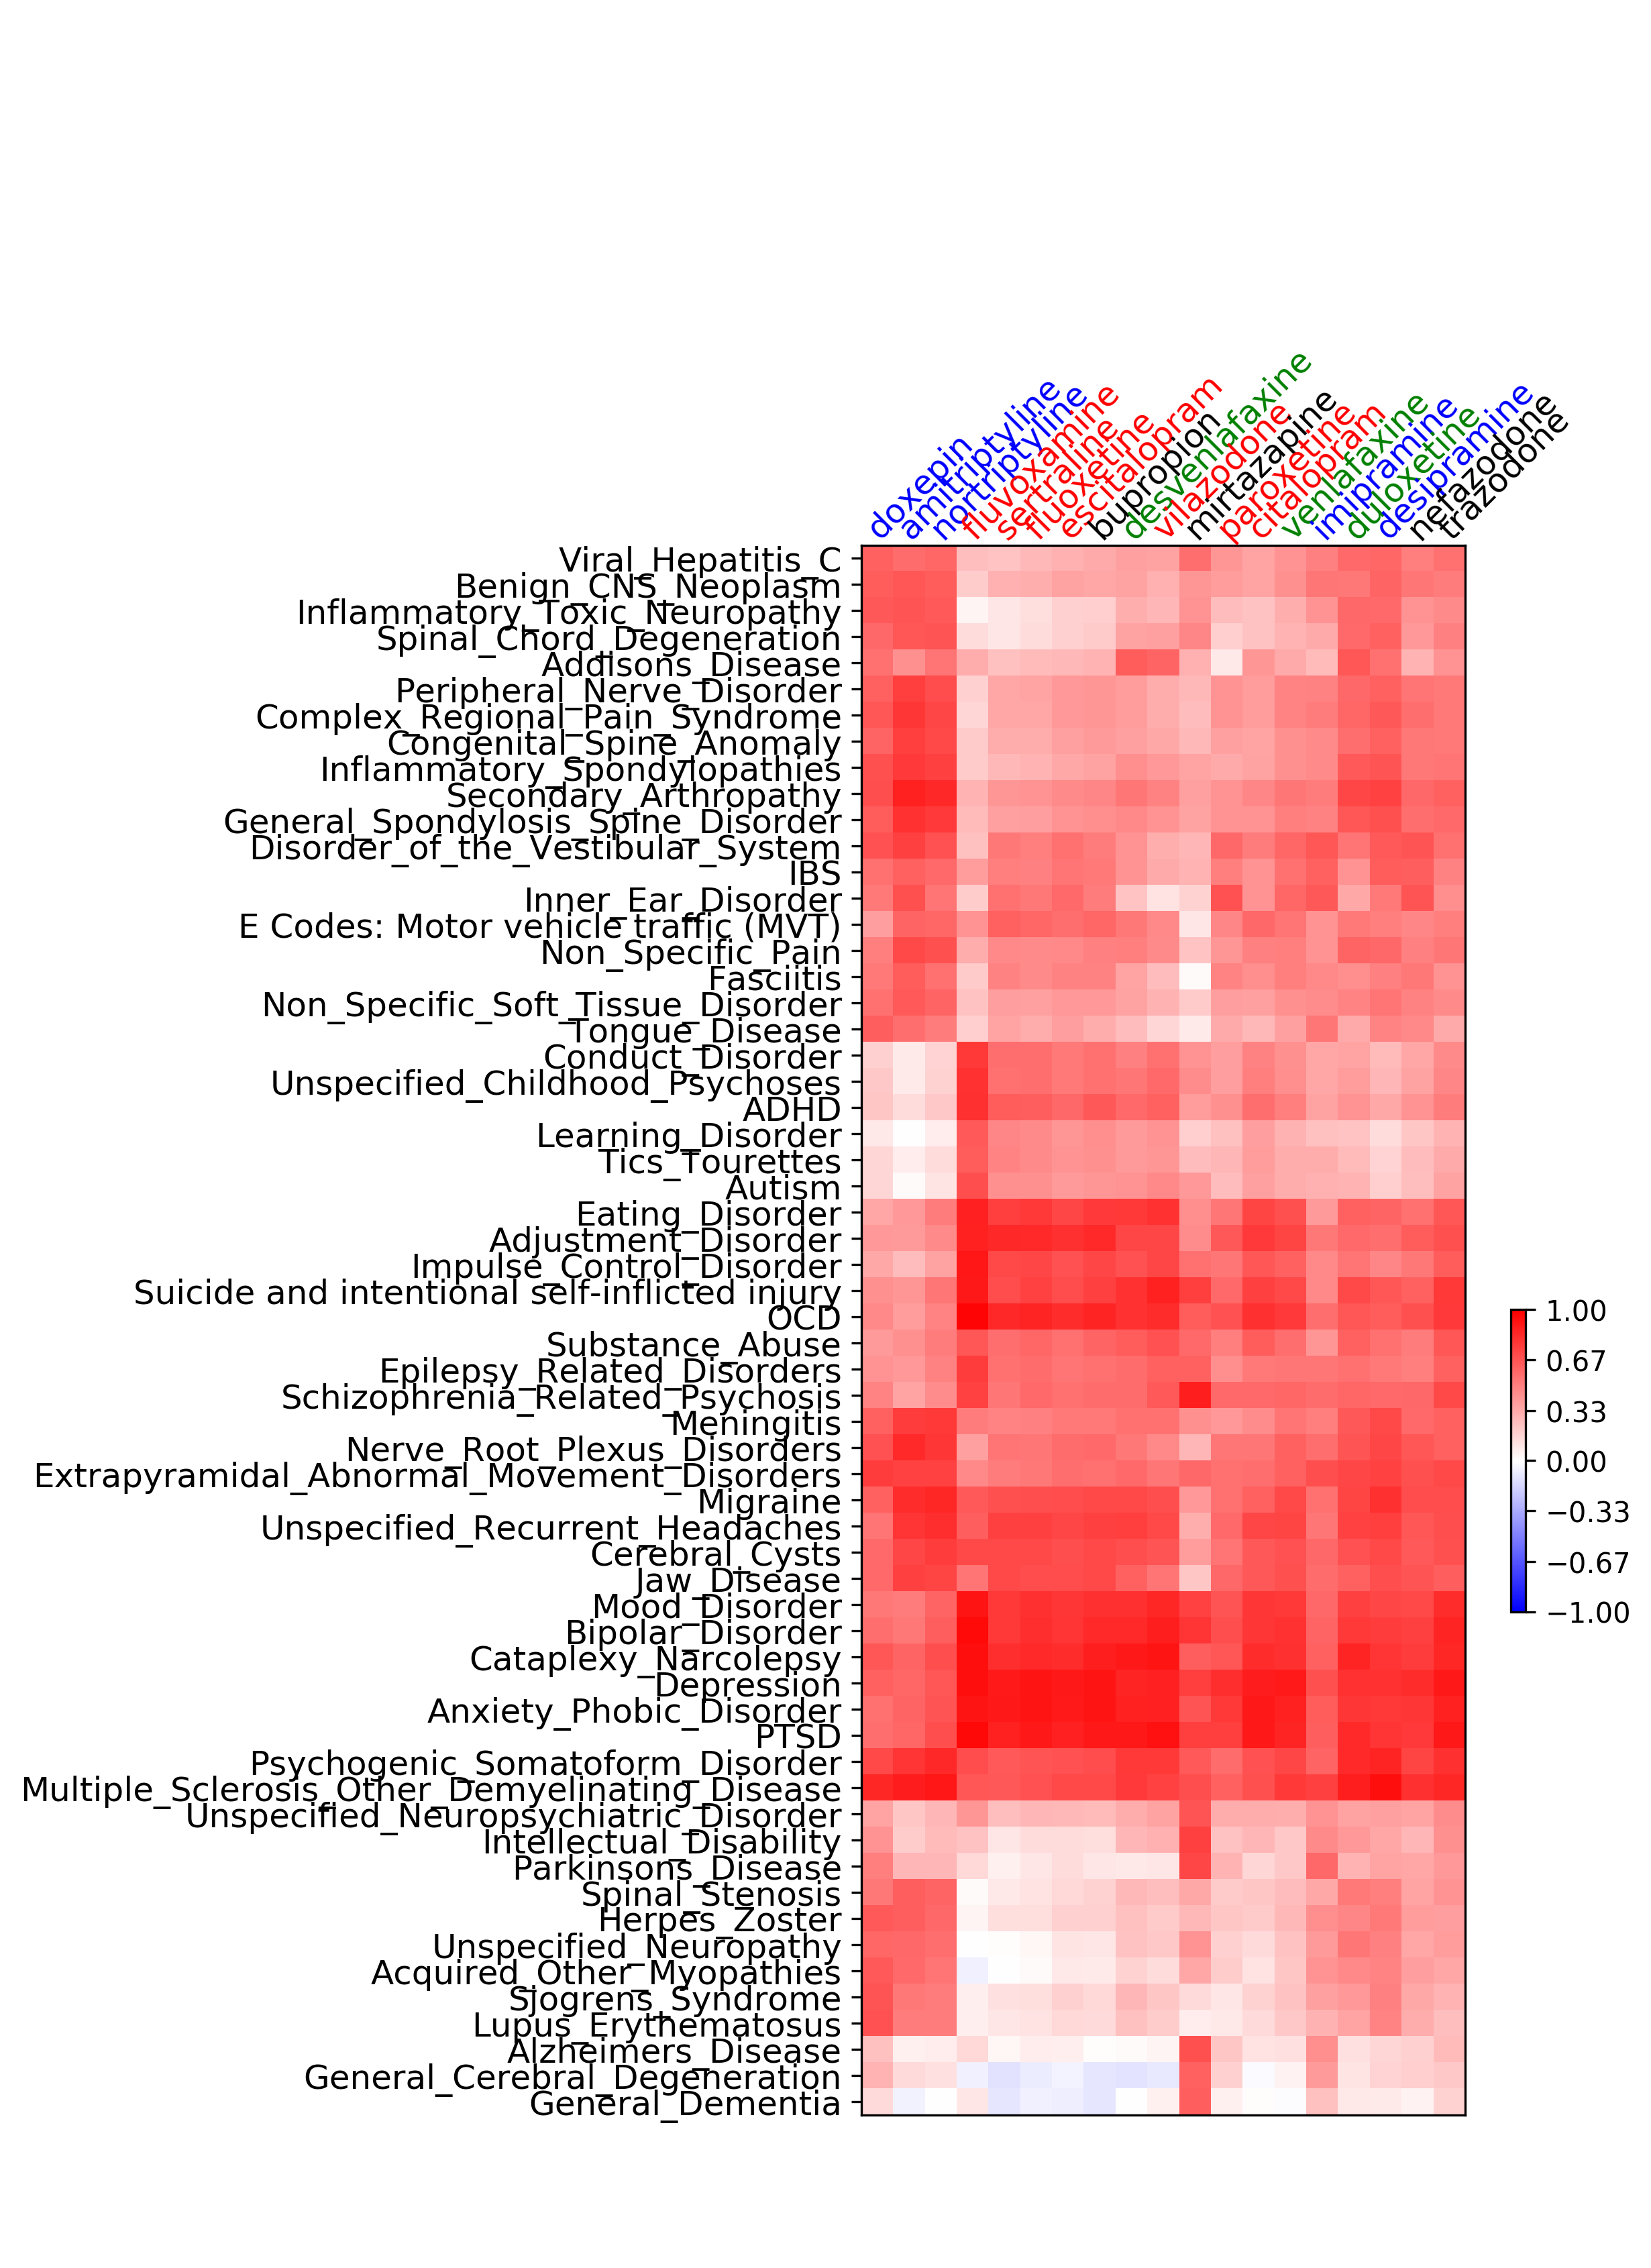

In [135]:
dep = {'SSRI':['paroxetine_hydrochloride','citalopram_hydrobromide','vilazodone_hydrochloride','fluvoxamine_maleate'
       ,'escitalopram_oxalate','fluoxetine_hydrochloride','sertraline_hydrochloride'],
    'SNRI':['venlafaxine_hydrochloride','duloxetine_hydrochloride','desvenlafaxine_succinate'],
    'TCA':['amitriptyline_hydrochloride','doxepin_hydrochloride','imipramine_hydrochloride','nortriptyline_hydrochloride',
      'desipramine_hydrochloride'],
       'buprop.':['bupropion_hydrochloride'],'mirtaz.':['mirtazapine'],
      'nefaz.':['nefazodone_hydrochloride']}

dxemb = dxemb.rename(index=dict(zip(*tuple((voc['vi'],voc['code'])))))
dxemb = dxemb.loc[dxemb.index != 'NA',:]
selrow = voc.set_index('code').loc[dxemb.index,'ct']
dxemb = dxemb.loc[selrow > 40000,:]

pheemb = pd.DataFrame(index= list(phe2icd.keys()),columns=np.arange(evemb.shape[1]))
for p in phe2icd:
    pheemb.loc[p,:] = dxemb.loc[set(phe2icd[p]) & set(dxemb.index),:].mean(axis=0).values
pheemb = pheemb.loc[(pd.isnull(pheemb).sum(axis=1)==0),:]
pheemb.to_csv("result_files/phenotype_embedding.txt",sep="\t")

d2c = pickle.load(open("annotations/drug2class.pkl",'rb'))
cl = [d for d,dc in d2c.items() if 'Psychother, Antidepressants' in dc]
antidepr_indic = rxemb.loc[set(cl) &  set(voc.loc[voc['ct'] > 40000,'name']) - set(['medical_food']),:]
#deprphe = antidepr_indic.transpose().dot(pheemb).transpose()
deprphe = pd.DataFrame(np.dot(antidepr_indic.values, pheemb.transpose().values),
                       index = antidepr_indic.index, columns = pheemb.index).transpose()
dplot = deprphe.loc[deprphe.max(axis=1) > .6,:]
dplot = dplot.astype(float)

import clustimg
f= clustimg.clust2way(dplot,'bwr',no_row_dendrogram=True ,tickfont=12,no_col_dendrogram=True)
f[0].set_size_inches((5,13))
f[1].set_xticklabels([])
f[1].set_xticks([])
#dplot.rename(columns={k:k.split("_")[0] for k in dplot.columns})
dpl = dplot.iloc[:,f[2]].columns

for ix, i in enumerate(dpl):
    color = 'k'
    if i in dep['TCA']:
        color = 'b'
    elif i in dep['SSRI']:
        color = 'r'
    elif i in dep['SNRI']:
        color = 'g'
    f[1].text(ix-.5,-.5,i.split("_")[0],rotation=45,ha='left',va='bottom',fontsize=12,color = color)
#f[0].savefig("antidepr-dx.tiff", bbox_inches="tight")
    

0 Impulse_Control_Disorder
1 Congenital_Spine_Anomaly
2 General_Cerebral_Degeneration
3 Conduct_Disorder
4 Bipolar_Disorder
5 Herpes_Zoster
6 IBS
7 Migraine
8 Intellectual_Disability
0


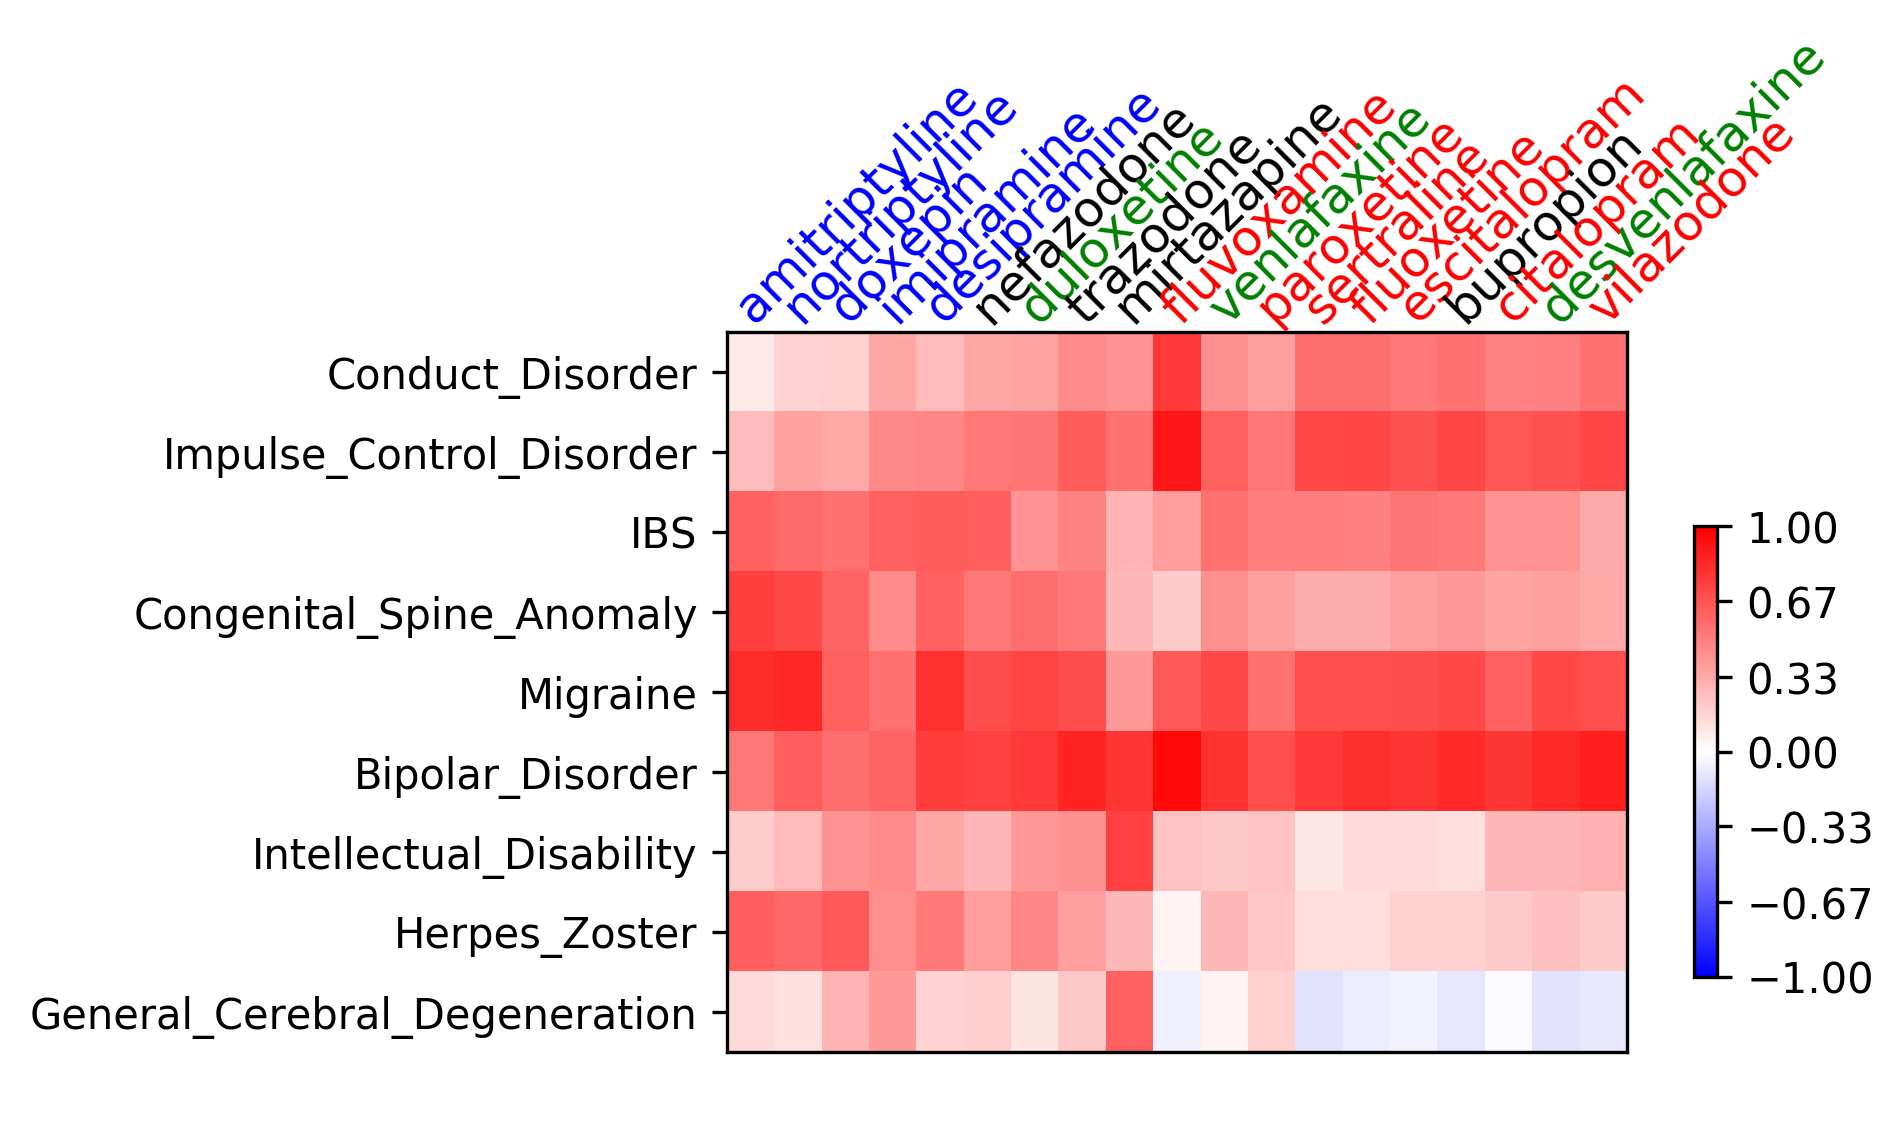

In [150]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
K = 9
kmeans = KMeans(init='k-means++', n_clusters=K, n_init=10)
lab = kmeans.fit_predict(dplot)
centers = kmeans.cluster_centers_
lab2 = pd.DataFrame(lab,index=dplot.index)

tosel = []
for i in range(K):

    dd = dplot.loc[lab2[0]==i,:]
    x = euclidean_distances(centers[i,:].reshape(1,-1),dd)
    tt = dd.loc[(x==x.min())[0,:],:].index[0]
    print(i,tt)
    tosel.append(tt)
    
import clustimg
f= clustimg.clust2way(dplot.loc[tosel,:],'bwr',no_row_dendrogram=True ,tickfont=10,no_col_dendrogram=True)
f[0].set_size_inches((5,4))
f[1].set_xticklabels([])
f[1].set_xticks([])
#dplot.rename(columns={k:k.split("_")[0] for k in dplot.columns})
dpl = dplot.iloc[:,f[2]].columns

for ix, i in enumerate(dpl):
    color = 'k'
    if i in dep['TCA']:
        color = 'b'
    elif i in dep['SSRI']:
        color = 'r'
    elif i in dep['SNRI']:
        color = 'g'
    f[1].text(ix-.5,-.5,i.split("_")[0],rotation=45,ha='left',va='bottom',fontsize=12,color = color)
#f

## Using embeddings to match patients in a cohort study

### Figure 6 Comparing matching of bupropion to trazodone patients

For the sake of visualization, I restricted this to men over 70 who took either drug in 2007. 

In [26]:
(pat_embed, ## 1448 patients x 50 columns of embedding per patient
 lab, ## whether patients took bupropion (0), trazodone (1), or varenicline (2)
 pat_ids, ## patient IDs (used for matching)
 nn, ## matching by nearest embedding neighbor (2 columns, each row is a pair of a bupropion patient and a trazodone patient)
 psm ## matching by propensity score, same format as above
) = pickle.load(open("data/bupropion_example_patient_embeddings.pkl",'rb'))
import umap
reducer = umap.UMAP()
uemb = reducer.fit_transform(pat_embed) ## create 2-D projection of patient embeddings


/home/melamed/.local/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../home/melamed/.local/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/melamed/.local/lib/python3.6/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../home/melamed/.local/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/melamed/.local/lib/python3.6/site-packages/numba/compiler.py:734: Numb

In [52]:
import plot_helper
def plot_matches(matches):
    sel = np.isin(pat_ids, np.reshape(matches,(-1,1))) | (lab==2)
    f, ax = plt.subplots(1,figsize=(4,5),dpi=300)
    sel = lab < 5
    a = sel & (lab==2) ## varenicline
    
    ax.plot(uemb[a,0],uemb[a,1],'.',color='khaki',markersize=10,label='varenicline')
    a = sel & (lab==0)
    ax.plot(uemb[a,0],uemb[a,1],'.',color='red',markersize=3,label='bupropion')
    a = sel & (lab==1)
    ax.plot(uemb[a,0],uemb[a,1],'.',color='blue',markersize=3,label='trazodone')    
    ax.set_xlim(np.percentile(uemb[:,0],[1,99]))

    emb = pd.DataFrame(uemb, index = pat_ids)
    lcy = list(zip(*tuple((np.ndarray.tolist(emb.loc[matches[:,0],:].values), 
                         np.ndarray.tolist(emb.loc[matches[:,1],:].values)))))
    from matplotlib import collections  as mc


    lc = mc.LineCollection(lcy,colors = 'k',linewidths=1)
    ax.add_collection(lc)
    plot_helper.trleg(ax)

    plot_helper.hideax(ax)

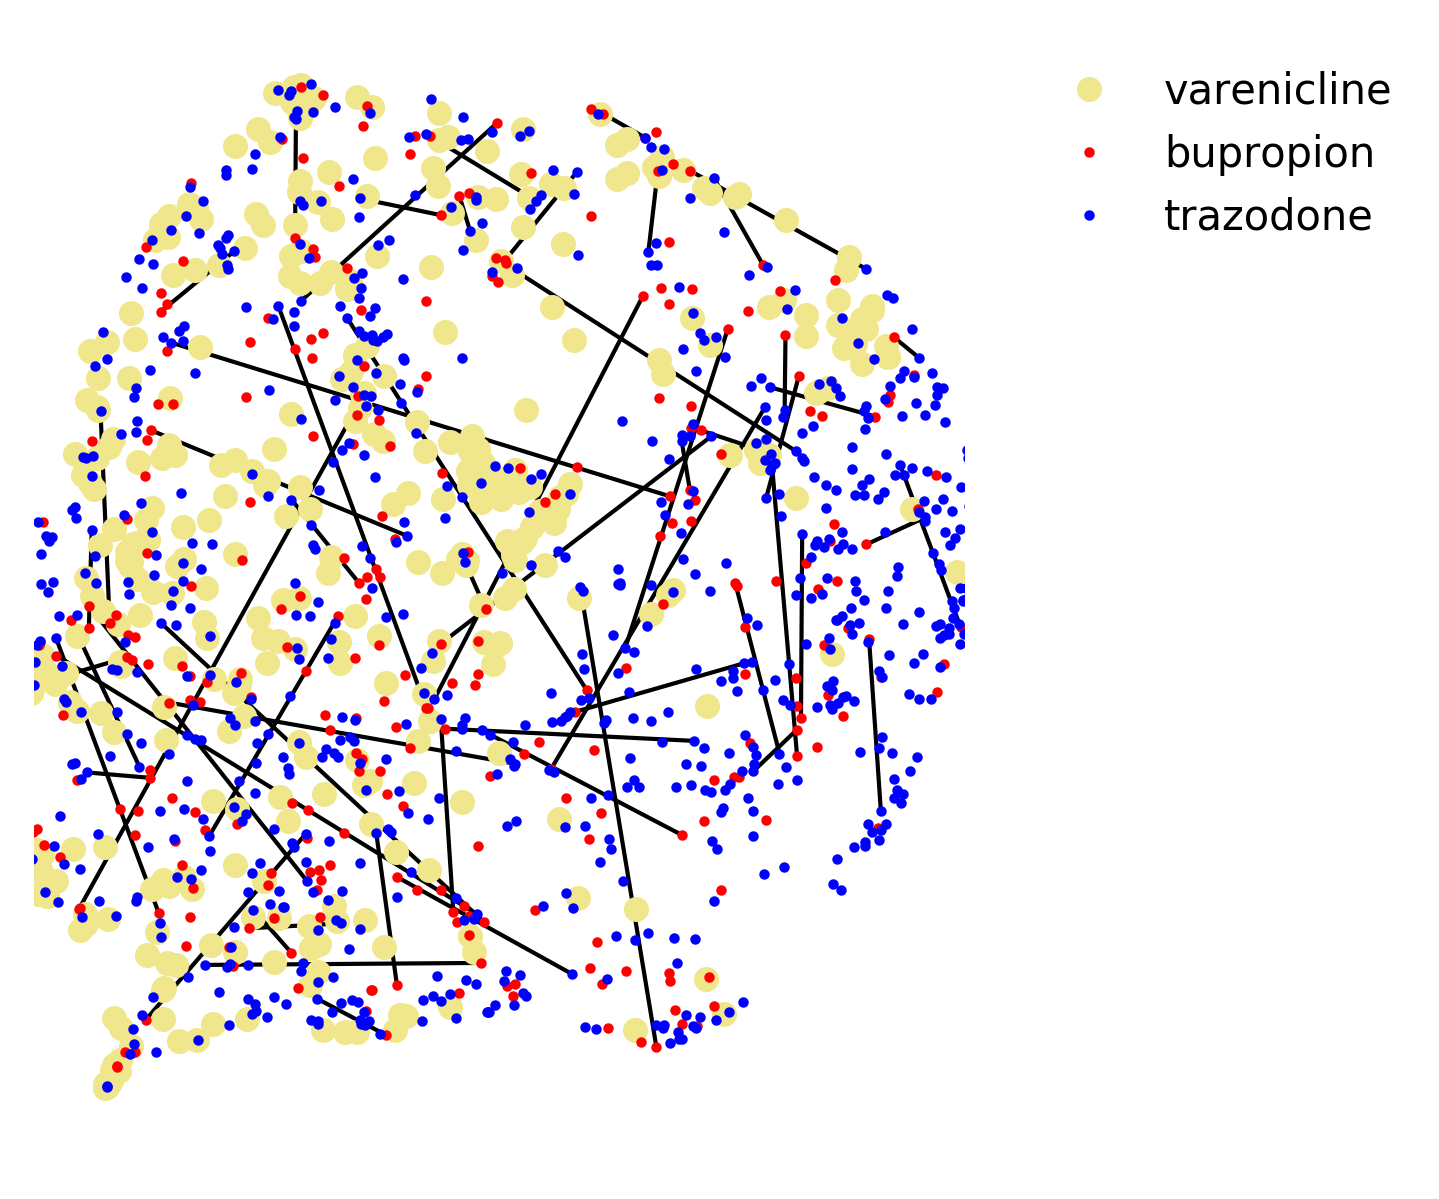

In [53]:
plot_matches(nn)

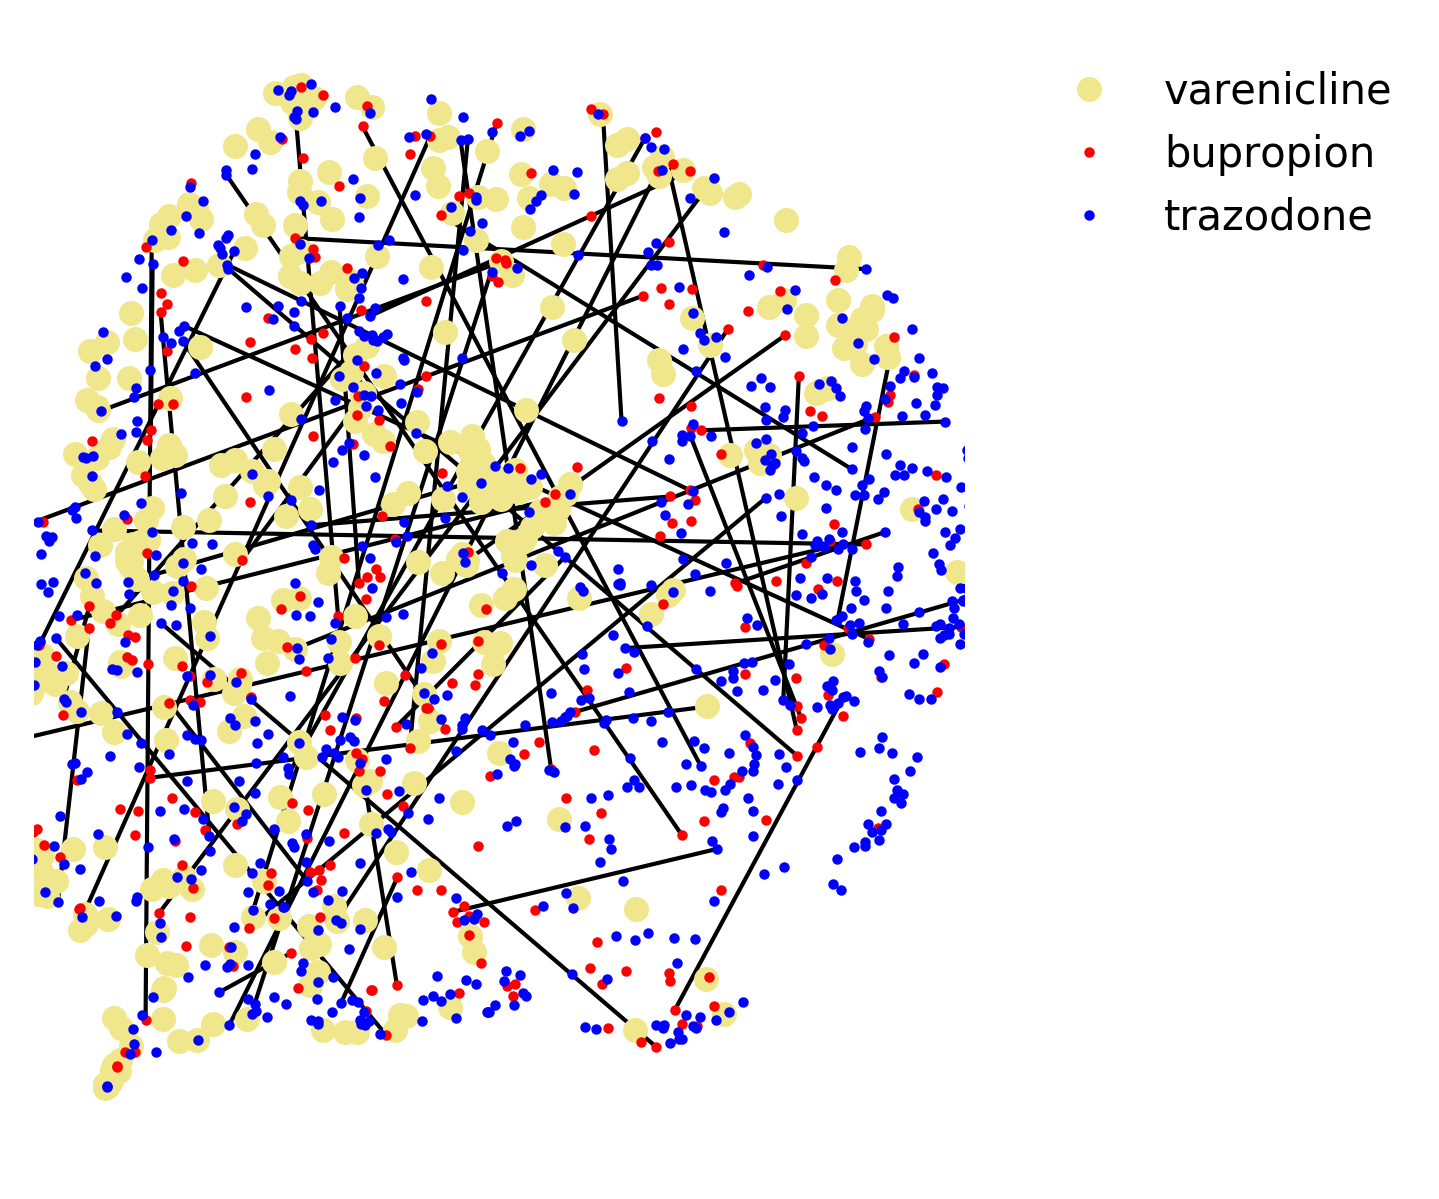

In [50]:
plot_matches(psm)

### Comparing if matches have similar smoking status scores
I load in the data to create the model. 

- `dat`: Each row is one patient and each column is one procedure, diagnosis, or drug. To remove any risk of reidentification of patients, there is no information about what each column corresponds to. 
- `smok_code`: presence or absence of the ICD-9 code 305.1, for smoking.

In [39]:
from scipy import sparse
dat = sparse.load_npz("data/pat_dat.npz")
smok_code = pd.read_table("data/pat_has_305.1.txt",index_col=0,header=None)
dat.shape

(599965, 11939)

Use SKLearn package to fit a simple logistic regression model to predict `smok_code` given `dat`.

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import SGDClassifier
def model_status(label, dat): 
    scaler = MaxAbsScaler()   
    tot_people = label.shape[0]

    class_weight = {i:tot_people/(2*ct) for i,ct in
                    enumerate([(label==0).sum(),(label==1).sum()])}
    iter = int(15000000)/label.shape[0]
    sgdmods = {}
    numfold = 5
    for l1 in [.2,.3]:
        for p in [.0001,.001,.01]:
            sgdmods[str(l1) + "-" + str(p)] = SGDClassifier(loss="log", penalty="elasticnet",
                                                alpha=p, l1_ratio=l1,max_iter=iter,
                                                         class_weight= class_weight)

    splits = np.array(list(np.arange(numfold))*int(1+tot_people/numfold))[:tot_people]       
    rocs = pd.DataFrame(index=sgdmods.keys(), columns=np.arange(numfold))        
    for f in range(numfold):
        print("starting fold:")
        scaler.fit(dat[splits!=f,:])
        #pdb.set_trace()        
        Xval = scaler.transform(dat[splits==f,:])
        X = scaler.transform(dat[splits!=f,:])
        print("about to fit fold:")
        for k in sgdmods:
            sgdmods[k].fit(X, label[splits!=f])
        labval = label[splits == f]
        print("about to eval fold:")            
        preds = {k:sgdmods[k].predict_proba(Xval)[:,1]
                 for k in sgdmods}
        for k in preds:
            roc = roc_auc_score(labval, preds[k])
            #if roc < .5:
            #    pdb.set_trace()
            print(k,roc)
            rocs.loc[k,f] = roc
    z = sgdmods[rocs.mean(axis=1).idxmax()].coef_
    mod =  sgdmods[rocs.mean(axis=1).idxmax()] # coef,  sgdmods[rocs.mean(axis=1).idxmax()]

    return pd.Series(mod.predict_proba(dat)[:,1], index = label.index)
    

In [ ]:
p_smoke = model_status(smok_code, dat)

The patients were matched either by Mahalanobis matching on the embedding vectors (`emb_match` below) or by PS matching (`ps_match`). Then, I compare how similar each matched pair is in smoking status using Spearman correlation:

In [38]:
emb_match = np.loadtxt("data/pat_matches_emb.txt")

ps_match = np.loadtxt("data/pat_matches_psm.txt")

dd = pd.DataFrame({'t':p_smoke.loc[ps_match[:,0]].values,'c':p_smoke.loc[ps_match[:,1]].values})
print("correlation between smoking status for PS match = {:1.2f}".format(stats.spearmanr(dd['t'],dd['c'])[0]))

dd = pd.DataFrame({'t':p_smoke.loc[emb_match[:,0]].values,'c':p_smoke.loc[emb_match[:,1]].values})
print("correlation between smoking status for embedding match = {:1.2f}".format(stats.spearmanr(dd['t'],dd['c'])[0]))

correlation between smoking status for PS match = 0.34
correlation between smoking status for embedding match = 0.57


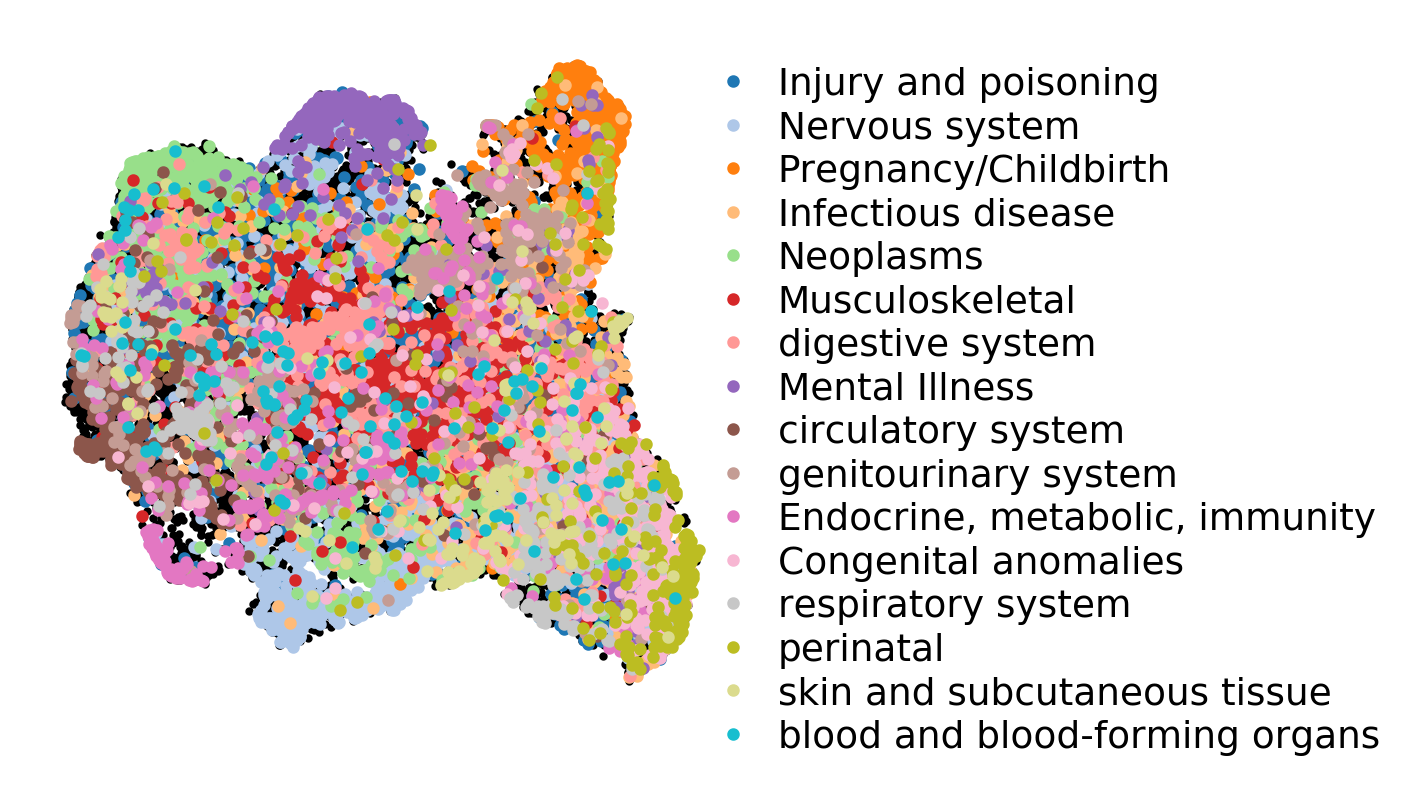

In [194]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
for r in ['Residual codes; unclassified; all E codes [259. and 260.]',
          'Symptoms; signs; and ill-defined conditions and factors influencing health status']:
    if r in ccsdo:
        ccsdo.remove(r)


ren = {cc:cc.replace('Diseases of the ','') for cc in ccsdo}

ren['Diseases of the nervous system and sense organs'] = 'Nervous system'
ren['Complications of pregnancy; childbirth; and the puerperium'] = 'Pregnancy/Childbirth'
ren['Diseases of the musculoskeletal system and connective tissue'] = 'Musculoskeletal'
ren['Endocrine; nutritional; and metabolic diseases and immunity disorders'] = 'Endocrine, metabolic, immunity'
ren['Infectious and parasitic diseases'] = 'Infectious disease'
ren['Certain conditions originating in the perinatal period'] = 'perinatal'

jet = plt.get_cmap('tab20')
cNorm = colors.Normalize(vmin=0, vmax=len(ccsdo))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

#dxfemb = dxfemb.rename(dict(zip(*tuple((voc['vi'],voc['code'])))))

jet = plt.get_cmap('tab20')
cNorm = colors.Normalize(vmin=0, vmax=len(ccsdo))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
f,ax = plt.subplots(1,figsize=(3,3), dpi=300)
ax.plot(umap_indications[0], umap_indications[1],".",color='k',markersize=2,label='_nolegend_')
for i,cc in enumerate(ccsdo):
    colorVal = scalarMap.to_rgba(i)
    subset = dxfemb.loc[dxfemb.index.isin(icd2ccs.loc[icd2ccs['ccs'].str.contains(cc),:].index),:]
    ax.plot(subset[0], subset[1],".",color=colorVal,markersize=4,label=ren[cc])
    
ax.legend(bbox_to_anchor=[.9,1], loc=2,frameon=False,fontsize=9, handletextpad= .2, labelspacing=.2)
plot_helper.hideax(ax)